# Clustering (K-means) on Wine Dataset

## Goal
Use k-means clustering to discover natural groupings in the Wine dataset.

Choose the number of clusters (k) using **Elbow (WCSS)** and **Silhouette score**, then visualise clusters with **PCA** and interpret them using feature means.

## Setup

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import load_wine
from sklearn.preprocessing import StandardScaler

## Dataset: Wine (sklearn built-in)
- 178 samples, 13 numeric chemical features.
- This is an **unsupervised** task: we do not use the true labels during clustering.
- Because k-means is distance-based, scaling is required.

In [ ]:
wine = load_wine()
X = pd.DataFrame(wine.data, columns=wine.feature_names)
#X is the conventional "feature matrix" variable name in machine learning, which facilitates subsequent unified calls.
#X是机器学习中约定俗成的 “特征矩阵” 变量名，方便后续统一调用。
print("Shape:", X.shape)
display(X.head())

Shape: (178, 13)


,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0


In [5]:
print("Missing values per column:")
display(X.isna().sum().sort_values(ascending=False).head(10))

Missing values per column:


alcohol                 0
malic_acid              0
ash                     0
alcalinity_of_ash       0
magnesium               0
total_phenols           0
flavanoids              0
nonflavanoid_phenols    0
proanthocyanins         0
color_intensity         0
dtype: int64

## Method

### Preprocessing (Scaling)
- StandardScaler (distance-based clustering is sensitive to feature magnitude)

### Model (K-means settings)
- init: k-means++
- n_init: 20
- random_state: 42
- k range tested: 2..10

In [6]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("Scaled shape:", X_scaled.shape)
print("Mean (first 5 features):", X_scaled.mean(axis=0)[:5])
print("Std  (first 5 features):", X_scaled.std(axis=0)[:5])

Scaled shape: (178, 13)
Mean (first 5 features): [ 7.84141790e-15  2.44498554e-16 -4.05917497e-15 -7.11041712e-17
 -2.49488320e-17]
Std  (first 5 features): [1. 1. 1. 1. 1.]


## Choosing k

### Elbow (WCSS)
WCSS (inertia) measures within-cluster sum of squared distances.

**This graph shows** how WCSS decreases as k increases; the “elbow” suggests diminishing returns after a certain k.

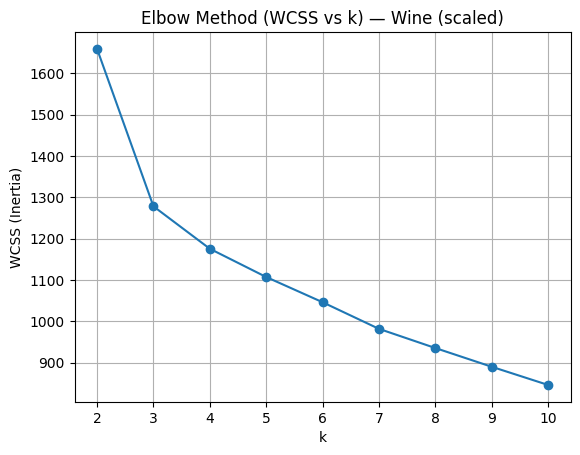

In [7]:
from sklearn.cluster import KMeans

ks = range(2, 11)
wcss = []

for k in ks:
    km = KMeans(n_clusters=k, init="k-means++", n_init=20, random_state=42)
    km.fit(X_scaled)
    wcss.append(km.inertia_)

plt.figure()
plt.plot(list(ks), wcss, marker="o")
plt.xlabel("k")
plt.ylabel("WCSS (Inertia)")
plt.title("Elbow Method (WCSS vs k) — Wine (scaled)")
plt.grid(True)
plt.savefig("../images/week01_elbow_wcss.png", dpi=200, bbox_inches="tight")
plt.show()

### Silhouette Score
Silhouette score evaluates how well-separated clusters are (range: -1 to 1).

**This graph shows** the average silhouette score for k=2..10; I select the k with the highest score (best separation/compactness).

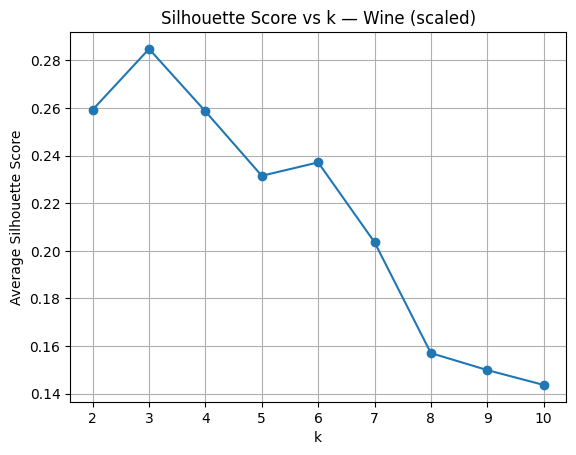

In [8]:
from sklearn.metrics import silhouette_score

sil_scores = []

for k in ks:
    km = KMeans(n_clusters=k, init="k-means++", n_init=20, random_state=42)
    labels = km.fit_predict(X_scaled)
    sil_scores.append(silhouette_score(X_scaled, labels))

plt.figure()
plt.plot(list(ks), sil_scores, marker="o")
plt.xlabel("k")
plt.ylabel("Average Silhouette Score")
plt.title("Silhouette Score vs k — Wine (scaled)")
plt.grid(True)
plt.savefig("../images/week01_silhouette_vs_k.png", dpi=200, bbox_inches="tight")
plt.show()

In [9]:
best_idx = int(np.argmax(sil_scores))
best_k = list(ks)[best_idx]
best_score = sil_scores[best_idx]

print("Best k by silhouette:", best_k)
print("Best silhouette score:", best_score)

Best k by silhouette: 3
Best silhouette score: 0.2848589191898987


## Final KMeans model (k=3)
I train the final model using:
- `init="k-means++"` for better initial centroids
- `n_init=20` to reduce sensitivity to random initialisation (local optimum issue)

In [10]:
final_k = 3

kmeans = KMeans(
    n_clusters=final_k,
    init="k-means++",
    n_init=20,
    random_state=42
)

cluster_labels = kmeans.fit_predict(X_scaled)

print("Final k:", final_k)
print("Final WCSS (inertia):", kmeans.inertia_)
print("Final silhouette:", silhouette_score(X_scaled, cluster_labels))

Final k: 3
Final WCSS (inertia): 1277.9284888446423
Final silhouette: 0.2848589191898987


## Visualisation — PCA (2D)
Wine has 13 dimensions, so I use **PCA** to project the scaled data into 2D for plotting.

**This plot shows** the cluster structure in PCA space (visualisation only; clustering is performed in the original scaled feature space).

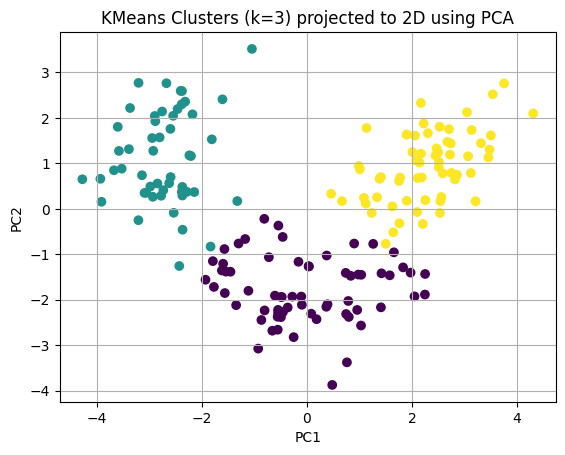

In [11]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

plt.figure()
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=cluster_labels)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("KMeans Clusters (k=3) projected to 2D using PCA")
plt.grid(True)
plt.savefig("../images/week01_pca_clusters_k3.png", dpi=200, bbox_inches="tight")
plt.show()

## Cluster interpretation (feature means)
To interpret the clusters, I compare feature means by cluster and focus on the features with the largest differences across clusters.

In [12]:
X_with_cluster = X.copy()
X_with_cluster["cluster"] = cluster_labels

cluster_means = X_with_cluster.groupby("cluster").mean(numeric_only=True)
display(cluster_means)

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
cluster,,,,,,,,,,,,,
0,12.250923,1.897385,2.231231,20.063077,92.738462,2.247692,2.050000,0.357692,1.624154,2.973077,1.062708,2.803385,510.169231
1,13.134118,3.307255,2.417647,21.241176,98.666667,1.683922,0.818824,0.451961,1.145882,7.234706,0.691961,1.696667,619.058824
2,13.676774,1.997903,2.466290,17.462903,107.967742,2.847581,3.003226,0.292097,1.922097,5.453548,1.065484,3.163387,1100.225806


In [13]:
ranges = cluster_means.max() - cluster_means.min()
top_features = ranges.sort_values(ascending=False).head(5).index.tolist()

print("Top 5 most different features across clusters:")
print(top_features)

display(cluster_means[top_features])

Top 5 most different features across clusters:
['proline', 'magnesium', 'color_intensity', 'alcalinity_of_ash', 'flavanoids']


,proline,magnesium,color_intensity,alcalinity_of_ash,flavanoids
cluster,,,,,
0,510.169231,92.738462,2.973077,20.063077,2.050000
1,619.058824,98.666667,7.234706,21.241176,0.818824
2,1100.225806,107.967742,5.453548,17.462903,3.003226


In [14]:
# Print the mean table of the 5 most critical features for writing reports
important = ['proline','magnesium','color_intensity','alcalinity_of_ash','flavanoids']
summary = cluster_means[important].round(2)
display(summary)

,proline,magnesium,color_intensity,alcalinity_of_ash,flavanoids
cluster,,,,,
0,510.17,92.74,2.97,20.06,2.05
1,619.06,98.67,7.23,21.24,0.82
2,1100.23,107.97,5.45,17.46,3.00


In [15]:
overall = X[important].mean()
diff = (cluster_means[important] - overall).round(2)
display(diff)

,proline,magnesium,color_intensity,alcalinity_of_ash,flavanoids
cluster,,,,,
0,-236.72,-7.00,-2.09,0.57,0.02
1,-127.83,-1.07,2.18,1.75,-1.21
2,353.33,8.23,0.40,-2.03,0.97
